# Dane Przestrzenne w Pythonie - wektory

| Metadane              | Wartość                                                                                                            |
|-----------------------|--------------------------------------------------------------------------------------------------------------------|
| Kurs - adres YT       | [Dane Przestrzenne w Pythonie - wektory](https://www.youtube.com/watch?v=UXjz7j_0FmY) |
| Część kursu           | 6 - Przestrzenne złączenia                                                                                       |
| Ostatnia aktualizacja | 2025-03-08                                                                                                         |
| Autor                 | Szymon Moliński                                                                                                    |



## Przestrzenne złączenia

Przestrzenne złączenia to bardzo przydatne operacje. Kiedy jedyną relacją między danymi jest ich położenie, nie mamy dostępu do żadnych indeksów, wtedy korzystamy z metod przestrzennego złączenia. Pokażemy to na przykładzie wcześniej eksplorowanego zbioru cen najmu krótkoterminowego AirBnB w Nowym Jorku.

`GeoPandas` oferuje kilka metod przestrzennego złączenia, wypróbujemy każdą z nich:

- `concat()`: dodawanie nowych wierszy albo kolumn do danych
- `merge()`: łączenie danych bazujące na wartościach z kolumn, z jednym zastrzeżeniemL: jeśli przyłączamy DataFrame do GeoDataFrame to wynikowo mamy GeoDataFrame. W odwrotnej sytuacji tracimy informacje przestrzenne i zostajemy z klasyczną ramką danych!
- `sjoin()`: przestrzenne złączenie.
- `sjoin_nearest()`: dołącza bliskie geometrie.

In [65]:
import sys

import pandas as pd
import geopandas as gpd

from geopandas import points_from_xy

In [2]:
B_FNAME = 'nybbwi_20d/nybbwi.shp'
B_FPATH = 'data/nybbwi_20d.zip'
B_ZIP_PATH = 'zip://' + B_FPATH + '!' + B_FNAME

AIRBNB_FPATH = 'data/AB_NYC_2019.csv'

ny = gpd.read_file(B_ZIP_PATH)
ab = pd.read_csv(AIRBNB_FPATH, index_col='id')

### `concat()`

In [3]:
# rozłóżmy dzielnice Nowego Jorku na pojedyncze geometrie

In [4]:
mnh = ny[ny['BoroName'] == 'Manhattan'].copy()
mnh

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184...."


In [5]:
# centroid manhattan
m_cent = ny[ny['BoroName'] == 'Manhattan'].centroid
m_cent

0    POINT (992576.281 221353.869)
dtype: geometry

In [6]:
# centroid brooklyn

b_cent = ny[ny['BoroName'] == 'Brooklyn'].centroid
b_cent

2    POINT (998185.377 170520.846)
dtype: geometry

In [7]:
# Sprawdźmy typy obiektów

type(mnh)

geopandas.geodataframe.GeoDataFrame

In [8]:
type(m_cent)

geopandas.geoseries.GeoSeries

In [9]:
type(b_cent)

geopandas.geoseries.GeoSeries

In [10]:
# Złączmy obiekty wierszami, jako kolejne rekordy

df = pd.concat([mnh, m_cent, b_cent])

In [11]:
df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,0
0,1.0,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",None
0,NaN,NaN,NaN,NaN,None,POINT (992576.281 221353.869)
2,NaN,NaN,NaN,NaN,None,POINT (998185.377 170520.846)


In [12]:
# Problem 1: indeksowanie

df = pd.concat([mnh, m_cent, b_cent], ignore_index=True)
df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,0
0,1.0,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",None
1,NaN,NaN,NaN,NaN,None,POINT (992576.281 221353.869)
2,NaN,NaN,NaN,NaN,None,POINT (998185.377 170520.846)


In [13]:
# reset_index() i do specjalnej kolumny dla bezpieczeństwa

In [14]:
# Problem 2: geometrie nie lądują w kolumnie 'geometry'

b_cent = gpd.GeoDataFrame(b_cent, columns=['geometry'])
m_cent = gpd.GeoDataFrame(m_cent, columns=['geometry'])

In [15]:
df = pd.concat([mnh, m_cent, b_cent], ignore_index=True)
df

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,1.0,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,NaN,NaN,NaN,NaN,POINT (992576.281 221353.869)
2,NaN,NaN,NaN,NaN,POINT (998185.377 170520.846)


In [16]:
type(df)

geopandas.geodataframe.GeoDataFrame

In [17]:
df.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [18]:
# ale

In [19]:
b_cent.to_crs(4326, inplace=True)
b_cent

,geometry
2,POINT (-73.94979 40.63471)


In [20]:
df = pd.concat([mnh, m_cent, b_cent], ignore_index=True)
df

ValueError: Cannot determine common CRS for concatenation inputs, got ['NAD83 / New York Long Island (ftUS)', 'WGS 84']. Use `to_crs()` to transform geometries to the same CRS before merging.

### `merge()`

Operacja `merge()` jest bardziej skomplikowana niż `concat()` ponieważ wymaga podania nazw kolumn, gdzie wspólne wartości będą używane do złączenia dwóch tabel. Spróbujemy złączyć tabelę z apartamentami w Nowym Jorku z danymi przestrzennymi - dzielnicami - wykorzystując do tego nazwę dzielnicy.

#### Połącz używając `neighbourhood_group` i `BoroName`

In [22]:
# Najpierw DataFrame a później GeoDataFrame

df_first = ab.merge(ny, left_on='neighbourhood_group', right_on='BoroName')

In [23]:
df_first.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ..."
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ..."
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184...."


In [24]:
type(df_first)

pandas.core.frame.DataFrame

In [25]:
# Najpierw GeoDataFrame a później DataFrame

gdf_first = ny.merge(ab, left_on='BoroName', right_on='neighbourhood_group')

In [26]:
type(gdf_first)

geopandas.geodataframe.GeoDataFrame

In [27]:
gdf_first.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
3,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
4,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220


In [28]:
# Dwa "ale"

In [29]:
# Ale 1: Projekcje się różnią
# Ale 2: Nie robimy plot() - mamy tysiące zduplikowanych geometrii! 
#.       Lepiej by było złączyć tylko indeksy przestrzennej ramki danych!

### `sjoin()`

Złączenie przestrzenne jest sednem używania `GeoPandas` zamiast `Pandas`, czy przestrzennych baz danych zamiast prostych relacyjnych systemów. System łączy ze sobą wiersze bazując na informacjach o zależności między geometriami, najważniejsze z zależności to:

- **intersects** - czy geometrie się przecinają
- **contains** - czy geometria zawiera inną geometrię
- **within** - czy geometria jest wewnątrz innej geometrii (nie liczy się granica!)
- **touches** - czy granice obiektów się stykają
- **crosses** - czy geometrie się przecinają
- **overlaps** - czy geometrie nakładają się na siebie

(Źródło: https://shapely.readthedocs.io/en/latest/manual.html#binary-predicates)

Złączenie przestrzenne zwraca indeksy do geometrii która spełnia dany warunek, dlatego lepiej sprawdzać relacje tej innej geometrii do prostych typów geometrii (nie przechowujemy wtedy w pamięci nadmiarowych danych).

In [31]:
points = points_from_xy(x=ab['longitude'], y=ab['latitude'], crs="EPSG:4326")
ab['coordinates'] = points
gdf = gpd.GeoDataFrame(ab)

In [32]:
gdf.set_geometry('coordinates', inplace=True)

In [33]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [34]:
ny.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [76]:
gdf.to_crs(ny.crs, inplace=True)
b_cent.to_crs(ny.crs, inplace=True)
mnh.to_crs(ny.crs, inplace=True)

In [36]:
# sjoin

<Axes: >

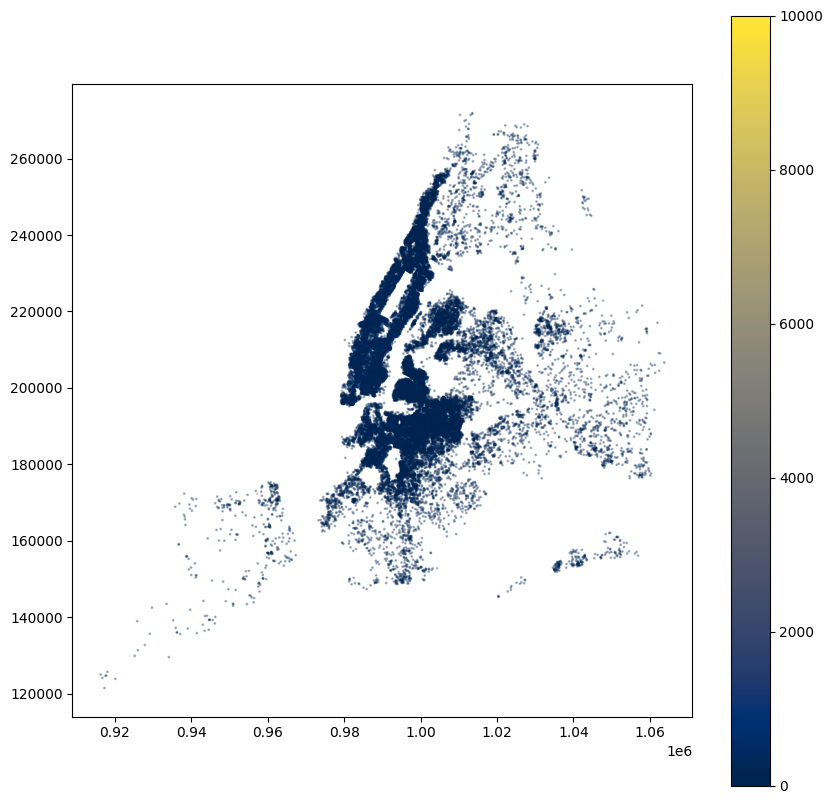

In [40]:
gdf.plot(alpha=0.3, column='price', legend=True, cmap='cividis', markersize=1, figsize=(10, 10))

<Axes: >

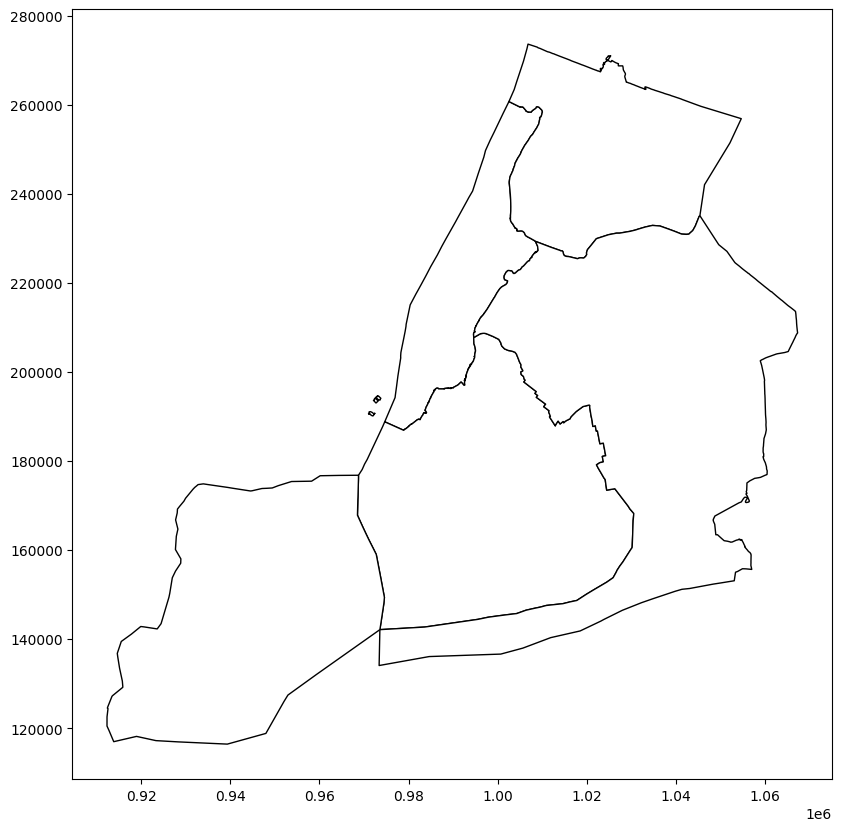

In [41]:
ny.plot(figsize=(10, 10), color='white', edgecolor='black')

In [44]:
b_cent

,geometry
2,POINT (998185.377 170520.846)


In [45]:
# within

In [46]:
sj_within = gpd.sjoin(ny, b_cent, how='left', predicate='within')
sj_within

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,index_right
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",NaN
1,2,Bronx,188054.198841,1.598380e+09,"POLYGON ((1021632.336 267934.439, 1022108.577 ...",NaN
2,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ...",NaN
3,4,Queens,429586.630985,3.858050e+09,"POLYGON ((1045438.075 235083.296, 1049675.845 ...",NaN
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",NaN


In [47]:
sj_within[~sj_within['index_right'].isna()]

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,index_right


In [48]:
sj_within = gpd.sjoin(b_cent, ny, how='left', predicate='within')
sj_within

,geometry,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
2,POINT (998185.377 170520.846),2,3,Brooklyn,234928.658563,2.684411e+09


In [49]:
ny.loc[sj_within['index_right']]

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
2,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ..."


In [50]:
# contains

In [51]:
sj_contains = gpd.sjoin(ny, b_cent, how='left', predicate='contains')

In [52]:
sj_contains.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,index_right
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",NaN
1,2,Bronx,188054.198841,1.598380e+09,"POLYGON ((1021632.336 267934.439, 1022108.577 ...",NaN
2,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ...",2.0
3,4,Queens,429586.630985,3.858050e+09,"POLYGON ((1045438.075 235083.296, 1049675.845 ...",NaN
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",NaN


In [53]:
sj_contains[~sj_contains['index_right'].isna()]

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,index_right
2,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ...",2.0


In [75]:
# intersects

In [77]:
sj_intersects = gpd.sjoin(ny, mnh, how='left', predicate='intersects')

In [78]:
sj_intersects

,BoroCode_left,BoroName_left,Shape_Leng_left,Shape_Area_left,geometry,index_right,BoroCode_right,BoroName_right,Shape_Leng_right,Shape_Area_right
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",0.0,1.0,Manhattan,203803.216852,9.442947e+08
1,2,Bronx,188054.198841,1.598380e+09,"POLYGON ((1021632.336 267934.439, 1022108.577 ...",0.0,1.0,Manhattan,203803.216852,9.442947e+08
2,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ...",0.0,1.0,Manhattan,203803.216852,9.442947e+08
3,4,Queens,429586.630985,3.858050e+09,"POLYGON ((1045438.075 235083.296, 1049675.845 ...",0.0,1.0,Manhattan,203803.216852,9.442947e+08
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",NaN,NaN,NaN,NaN,NaN


<Axes: >

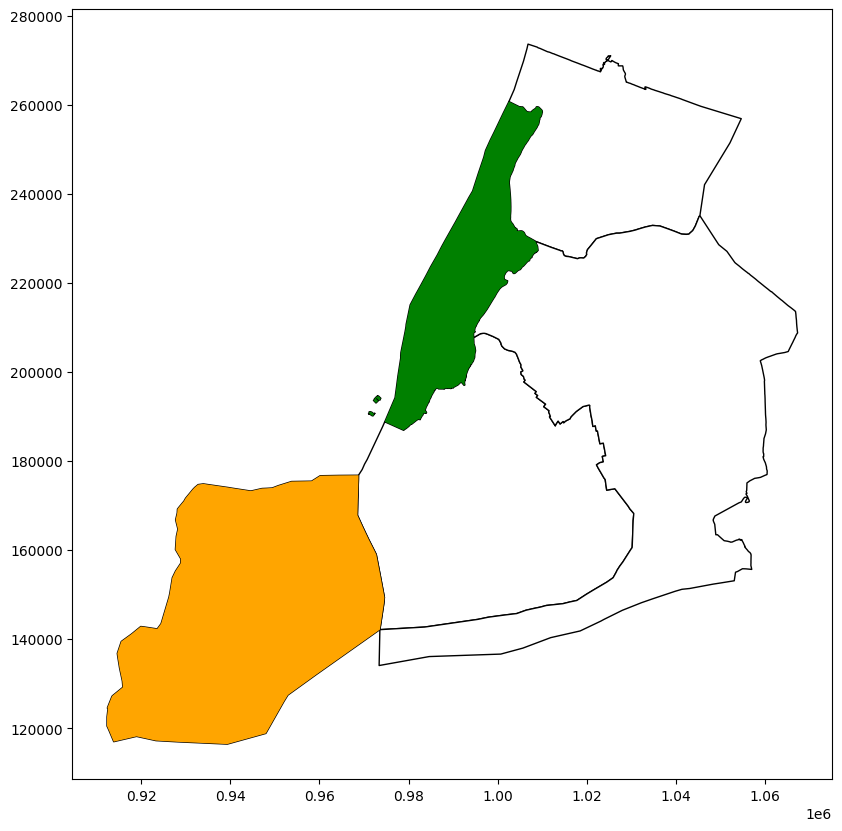

In [80]:
base = ny.plot(figsize=(10, 10), color='white', edgecolor='black');
sj_intersects[sj_intersects['index_right'].isna()].plot(ax=base, color='orange')
mnh.plot(ax=base, color='green')

In [81]:
sj_intersects = gpd.sjoin(mnh, ny, how='left', predicate='intersects')
sj_intersects

,BoroCode_left,BoroName_left,Shape_Leng_left,Shape_Area_left,geometry,index_right,BoroCode_right,BoroName_right,Shape_Leng_right,Shape_Area_right
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",2,3,Brooklyn,234928.658563,2.684411e+09
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",3,4,Queens,429586.630985,3.858050e+09
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",0,1,Manhattan,203803.216852,9.442947e+08
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",1,2,Bronx,188054.198841,1.598380e+09


In [83]:
sj_intersects = gpd.sjoin(b_cent, ny, how='left', predicate='intersects')
sj_intersects

,geometry,index_right,BoroCode,BoroName,Shape_Leng,Shape_Area
2,POINT (998185.377 170520.846),2,3,Brooklyn,234928.658563,2.684411e+09


In [84]:
# touches

In [85]:
sj_touches = gpd.sjoin(ny, mnh, how='left', predicate='touches')
sj_touches

,BoroCode_left,BoroName_left,Shape_Leng_left,Shape_Area_left,geometry,index_right,BoroCode_right,BoroName_right,Shape_Leng_right,Shape_Area_right
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",NaN,NaN,NaN,NaN,NaN
1,2,Bronx,188054.198841,1.598380e+09,"POLYGON ((1021632.336 267934.439, 1022108.577 ...",NaN,NaN,NaN,NaN,NaN
2,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ...",NaN,NaN,NaN,NaN,NaN
3,4,Queens,429586.630985,3.858050e+09,"POLYGON ((1045438.075 235083.296, 1049675.845 ...",NaN,NaN,NaN,NaN,NaN
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",NaN,NaN,NaN,NaN,NaN


In [88]:
sj_touches = gpd.sjoin(ny, gdf, how='left', predicate='touches')
sj_touches[~sj_touches['id'].isna()]

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,id,name,host_id,host_name,neighbourhood_group,...,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


In [89]:
# crosses

In [90]:
sj_crosses = gpd.sjoin(ny, mnh, how='left', predicate='crosses')
sj_crosses

,BoroCode_left,BoroName_left,Shape_Leng_left,Shape_Area_left,geometry,index_right,BoroCode_right,BoroName_right,Shape_Leng_right,Shape_Area_right
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",NaN,NaN,NaN,NaN,NaN
1,2,Bronx,188054.198841,1.598380e+09,"POLYGON ((1021632.336 267934.439, 1022108.577 ...",NaN,NaN,NaN,NaN,NaN
2,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ...",NaN,NaN,NaN,NaN,NaN
3,4,Queens,429586.630985,3.858050e+09,"POLYGON ((1045438.075 235083.296, 1049675.845 ...",NaN,NaN,NaN,NaN,NaN
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",NaN,NaN,NaN,NaN,NaN


In [91]:
# overlaps

In [92]:
sj_overlaps = gpd.sjoin(ny, mnh, how='left', predicate='overlaps')
sj_overlaps

,BoroCode_left,BoroName_left,Shape_Leng_left,Shape_Area_left,geometry,index_right,BoroCode_right,BoroName_right,Shape_Leng_right,Shape_Area_right
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",NaN,NaN,NaN,NaN,NaN
1,2,Bronx,188054.198841,1.598380e+09,"POLYGON ((1021632.336 267934.439, 1022108.577 ...",0.0,1.0,Manhattan,203803.216852,9.442947e+08
2,3,Brooklyn,234928.658563,2.684411e+09,"POLYGON ((1004421.481 203543.225, 1004612.108 ...",0.0,1.0,Manhattan,203803.216852,9.442947e+08
3,4,Queens,429586.630985,3.858050e+09,"POLYGON ((1045438.075 235083.296, 1049675.845 ...",0.0,1.0,Manhattan,203803.216852,9.442947e+08
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",NaN,NaN,NaN,NaN,NaN


<Axes: >

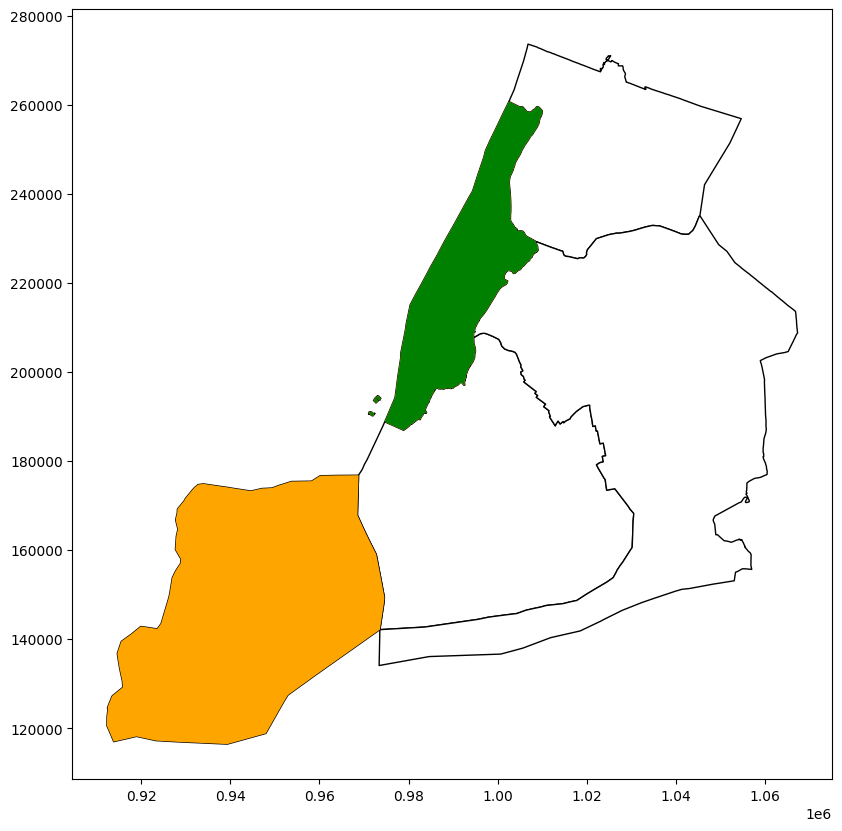

In [93]:
base = ny.plot(figsize=(10, 10), color='white', edgecolor='black');
sj_overlaps[sj_overlaps['index_right'].isna()].plot(ax=base, color='orange')
mnh.plot(ax=base, color='green')

### `sjoin_nearest()`

Teraz poeksperymentujemy z metodą łączenia geometrii na podstawie ich bliskości (dystansu). Najpierw - apartament najbliższy centroidowi Brooklyn-u.

In [96]:
closest = gpd.sjoin_nearest(b_cent, gdf, distance_col='distance')

In [97]:
closest

,geometry,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,distance
2,POINT (998185.377 170520.846),21835893,"Artist Flat, 5 min walk to Metro 30 mins from JFK",16356565,Shirley,Brooklyn,Flatbush,40.63435,-73.95027,Entire home/apt,95,2,41,2019-05-27,2.13,2,0,185.530829


In [99]:
closest = gpd.sjoin_nearest(ny, gdf, distance_col='distance')

In [100]:
closest

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,id,name,host_id,host_name,neighbourhood_group,...,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,distance
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",31168781,Amazing cozy and warm male room on Manhattan IV,170263842,Sultan,Manhattan,...,-73.98822,Shared room,35,14,0,NaN,NaN,4,334,0.0
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",25948942,Lovely room in Manhattan Lower East Side,131236711,Qi,Manhattan,...,-73.98738,Private room,80,1,11,2018-07-13,0.85,1,0,0.0
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",2084817,Huge Bedroom at Downtown Manhattan,2657134,Luna,Manhattan,...,-73.98756,Private room,128,1,16,2018-02-28,0.75,1,0,0.0
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",25499011,NEW Wonderful private room near Two Bridges II,39528519,Max,Manhattan,...,-73.98759,Private room,91,15,0,NaN,NaN,28,184,0.0
0,1,Manhattan,203803.216852,9.442947e+08,"MULTIPOLYGON (((972081.788 190733.467, 972184....",23385738,Male room 2 minutes from East Broadway station...,170263842,Sultan,Manhattan,...,-73.98727,Shared room,32,14,0,NaN,NaN,4,341,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",23247442,"Contemporary Home Away from Home, Entire house",499896,Leon,Staten Island,...,-74.08136,Entire home/apt,245,2,37,2019-06-01,2.28,1,216,0.0
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",18305741,Cozy Room Minutes To Manhattan. #2,72603148,Faye,Staten Island,...,-74.07842,Private room,55,1,13,2019-03-20,0.48,3,362,0.0
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",20055311,Cozy Basement Apartment near RUMC Hospital,318899,Krystal,Staten Island,...,-74.10942,Entire home/apt,75,1,9,2019-06-07,0.45,1,175,0.0
4,5,Staten Island,212213.139971,2.539686e+09,"POLYGON ((968762.067 175987.749, 968654.251 17...",31560479,large private Rooms for rent 5 mins from SI Ferry,236556387,Samuel,Staten Island,...,-74.07758,Private room,57,1,7,2019-06-22,3.56,1,365,0.0


---